![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Image Analysis: The Attention Maps

### Imports

Let's start with importing all required Python packages.

In [1]:
%matplotlib inline
import sys
import os
import json
import ipywidgets as widgets

from PIL import Image as PILImage
import torchvision
from torchvision import transforms
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 

import shap
# import warnings
# warnings.filterwarnings("ignore")

import utils
sys.path.append('../data_and_models/')
from vit import VitGenerator

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Data and Model Loading

We first load the image we want to analyse and the model we use for predicton.

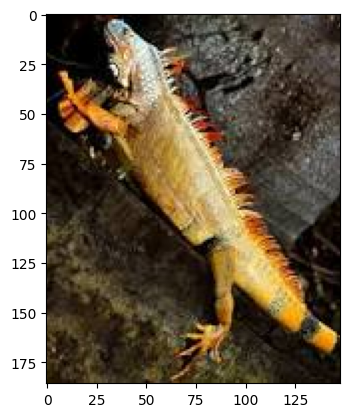

In [3]:
# read and visualize the image
path_to_img = '../data_and_models/images/Iguana.jpeg'
img = utils.read_img(path_to_img)
plt.imshow(img)
plt.show()

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

Before we can use the image, we need to convert the image to RGB channel, transform the image (convert to PIL format, resize to lower resolution, convert to tensor dtype and normalize the pixel values) and unsqueeze the image to add a batch dimension.

In [4]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_size = tuple(np.array(img.shape[:-1]) // 2) 
img_trans = utils.transform_img(img, mean, std, img_size=img_size)

We use either cpu or gpu according to the available device

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(1)

We define a vision transformer that we will use for the classifcation of the image that we just loaded. 
We have the choice between three pretrained transformer models: vit_tiny, vit_small, and vit_base.
In out tutorial we will use vit_small. 

In [6]:
name_model = 'vit_small'
patch_size = 8

model = VitGenerator(name_model, patch_size, 
                     device, evaluate=True, random=False, verbose=True)

[INFO] Initializing vit_small with patch size of 8
[INFO] Loading weights


Extract the attention maps

In [7]:
# make the image divisible by the patch size
w, h = img_trans.shape[1] - img_trans.shape[1] % patch_size, img_trans.shape[2] - img_trans.shape[2] % patch_size
# img_trans = img_trans[:, :w, :h].unsqueeze(0)

w_featmap = img_trans.shape[-2] // patch_size
h_featmap = img_trans.shape[-1] // patch_size

attentions = model.get_last_selfattention(img_trans.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
attentions = attentions.reshape(nh, w_featmap, h_featmap)

attentions = nn.functional.interpolate(attentions.unsqueeze(0), (186, 148), mode="bilinear")[0].detach().numpy()


In [8]:
def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig)
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i])
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()

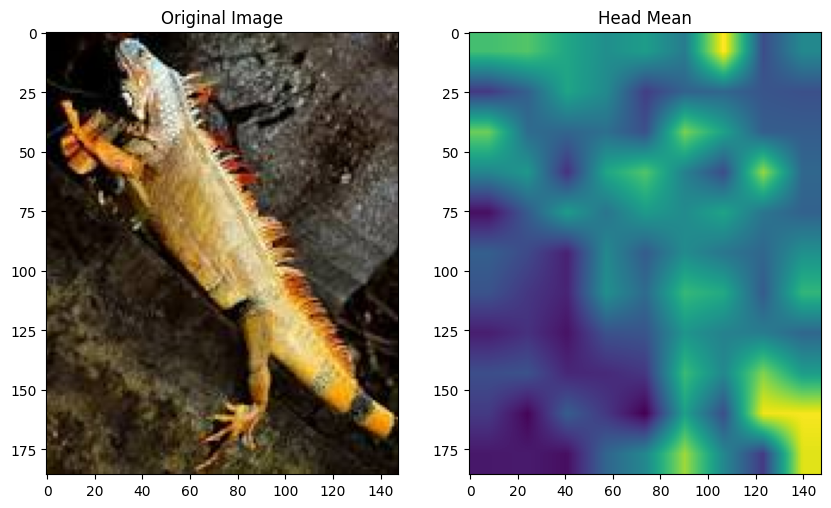

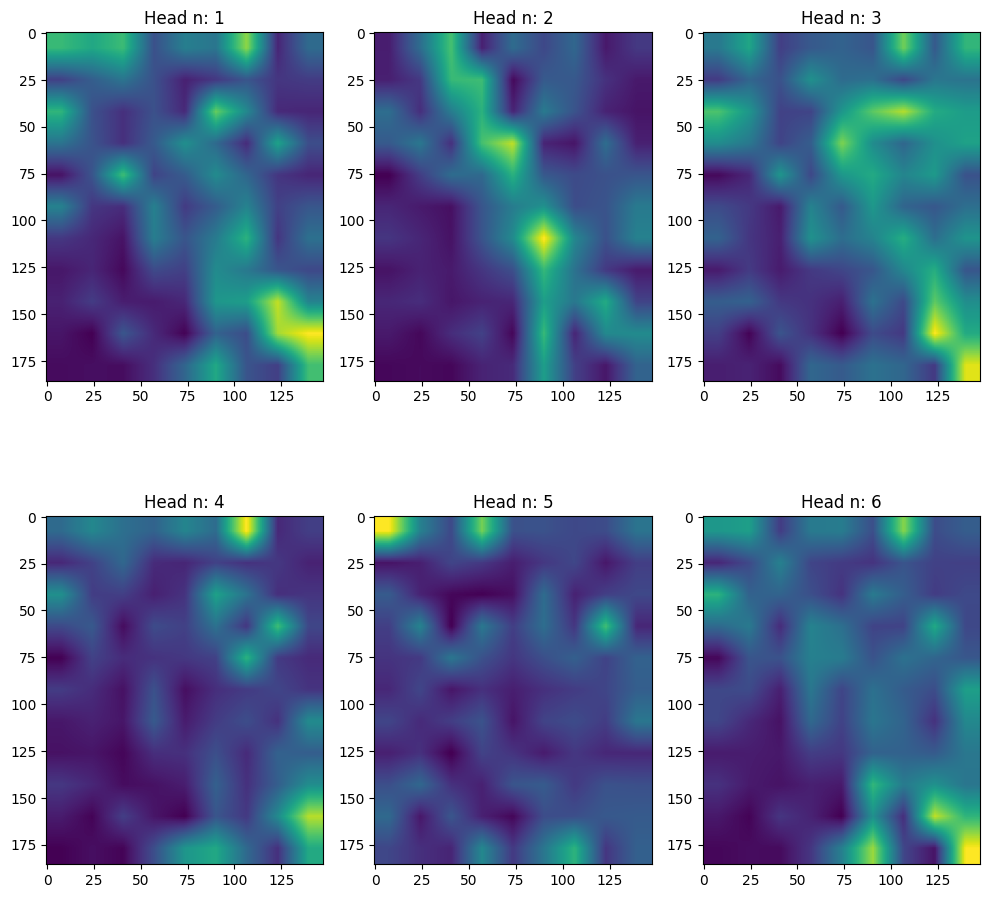

In [9]:
plot_attention(img, attentions)

In [ ]:
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join("xai-model-specific", "img.png"))
for j in range(nh):
    fname = os.path.join("xai-model-specific", "attn-head" + str(j) + ".png")
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    print(f"{fname} saved.")

In [11]:
def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img


def visualize_predict(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig)
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i])
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()


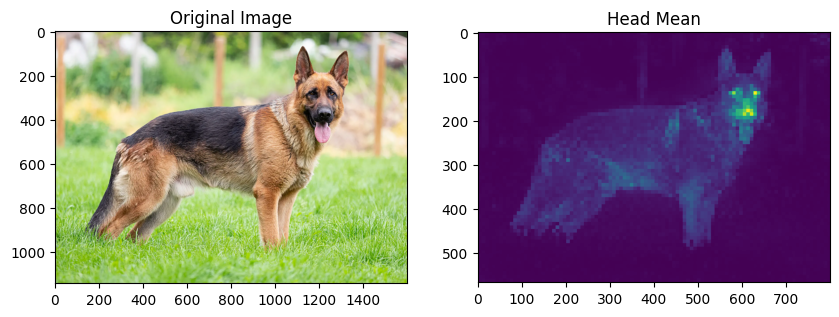

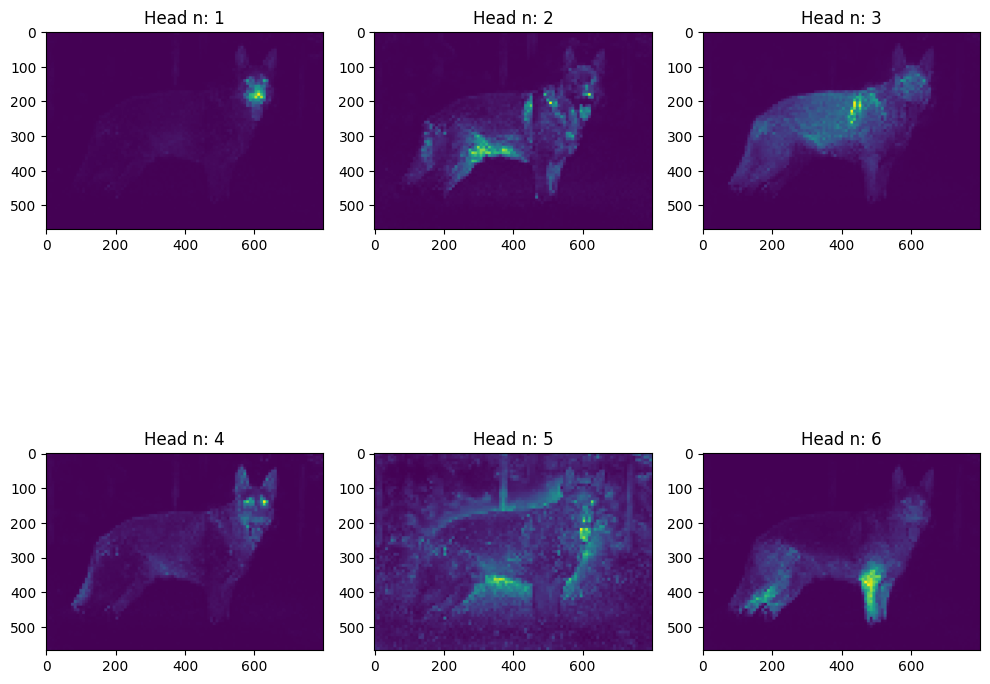

In [12]:
path = "/p/project/hai_squi4mi/benassou1/Squiggle-Project2/model_training_SN/German-Shepherd-dog-Alsatian.jpeg"
img = PILImage.open(path)
factor_reduce = 2
img_size = tuple(np.array(img.size[::-1]) // factor_reduce) 
visualize_predict(model, img, img_size, patch_size, device)